# HW11 Deep learning practical intro

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
from string import punctuation

import gensim
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Делаем классификацию на torch

#### Подготовим данные 

In [2]:
data = pd.read_csv('quora.csv')
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [3]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [5]:
vocab = Counter()

for text in data.question_text:
    vocab.update(preprocess(text))

In [10]:
len(vocab)

273056

In [11]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [12]:
len(filtered_vocab)

14083

In [13]:
word2id = {'PAD':0}
for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [14]:
id2word = {i:word for word, i in word2id.items()}

In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset, word2id, MAX_LEN, text_field, target_field):
        
        self.dataset = dataset[text_field].values
        
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset[target_field].values)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        tokens = self.preprocess(self.dataset[index])
        ids = [self.word2id[token] for token in tokens if token in self.word2id][:MAX_LEN]
        ids = torch.nn.functional.pad(torch.LongTensor(ids), 
                                (0, self.MAX_LEN-len(ids)), 
                                mode='constant',
                                value=0)
        y = self.target[index]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [16]:
MAX_LEN = 100
RANDOM_SEED = 23
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
train_dataset, valid_dataset = train_test_split(data, test_size=0.05, random_state=RANDOM_SEED, stratify=data.target)

In [21]:
training_set = Dataset(train_dataset, word2id, MAX_LEN, 'question_text', 'target')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'question_text', 'target')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)
print('train data:', len(train_dataset), 'valid data:', len(valid_dataset))

train data: 1240815 valid data: 65307


In [25]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions.float(), ys.to(device).float())        
        acc = binary_accuracy(predictions.float(), ys.to(device).float())
        loss.backward()     
        
        optimizer.step()      
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}; Accuracy: {epoch_acc/i}')
        
    return epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.float(), ys.to(device).float())        
            acc = binary_accuracy(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()  
            epoch_acc += acc.item()
            
    return epoch_acc / len(iterator)

## 1. a) Конкатенируем эмбединги в один большой эмбединг

In [35]:
class Clf_flatten(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        embedded_mean = torch.mean(embedded, dim=1)
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [36]:
model = Clf_flatten(len(word2id), embedding_dim=30, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [37]:
%%time
accs = []
accs_eval = []
for i in range(5):
    print('epoch:', i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

epoch: 0
Loss: 0.24181512908057287; Accuracy: 0.9387160598098098
Loss: 0.22611440297005592; Accuracy: 0.9384086574537268
Loss: 0.21148664028535646; Accuracy: 0.9388637358286095
Loss: 0.198300948433129; Accuracy: 0.9399791354088523
epoch: 1
Loss: 0.145736865460634; Accuracy: 0.9469821383883884
Loss: 0.14317663983367812; Accuracy: 0.9473095922961481
Loss: 0.14127500575854404; Accuracy: 0.9476661491330444
Loss: 0.13935613724426138; Accuracy: 0.9481491466616654
epoch: 2
Loss: 0.13148896863779147; Accuracy: 0.9510447947947948
Loss: 0.13057450456297834; Accuracy: 0.9509696254377189
Loss: 0.1298138218391196; Accuracy: 0.9509680310103368
Loss: 0.1289431797976299; Accuracy: 0.9511078941610402
epoch: 3
Loss: 0.12579599857046916; Accuracy: 0.952733983983984
Loss: 0.125342135923752; Accuracy: 0.9525329070785392
Loss: 0.12488256890491949; Accuracy: 0.952445085861954
Loss: 0.12430602481351641; Accuracy: 0.9525242638784697
epoch: 4
Loss: 0.12256507727283018; Accuracy: 0.953832738988989
Loss: 0.122320

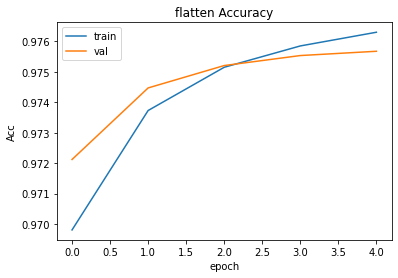

In [38]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('flatten Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [40]:
print(classification_report(targets, (np.array(preds) > 0.3).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     61266
         1.0       0.62      0.58      0.60      4041

    accuracy                           0.95     65307
   macro avg       0.80      0.78      0.79     65307
weighted avg       0.95      0.95      0.95     65307



## 1. б) Усредним эмбединги

In [41]:
class Clf_mean(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        embedded_mean = torch.mean(embedded, dim=1)
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [42]:
model = Clf_mean(len(word2id), embedding_dim=40, output_dim=1)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [44]:
%%time
accs = []
accs_eval = []
for i in range(5):
    print('epoch:', i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

epoch: 0
Loss: 0.16840910983157228; Accuracy: 0.9420279654654654
Loss: 0.1670099409476944; Accuracy: 0.9417970704102051
Loss: 0.1660798907990494; Accuracy: 0.9418946940646882
Loss: 0.16480583795929707; Accuracy: 0.9421925793948487
epoch: 1
Loss: 0.16052054767464255; Accuracy: 0.9433652402402403
Loss: 0.15947908904028868; Accuracy: 0.9432040238869435
Loss: 0.1588818003343081; Accuracy: 0.9432219594031344
Loss: 0.15788930393131292; Accuracy: 0.9434428919729932
epoch: 2
Loss: 0.15523866537186476; Accuracy: 0.9446282219719719
Loss: 0.15438800999869579; Accuracy: 0.9444487868934467
Loss: 0.15395591876315212; Accuracy: 0.9443304018006002
Loss: 0.15311260056938342; Accuracy: 0.9444978432108027
epoch: 3
Loss: 0.1512766502894558; Accuracy: 0.9454493556056056
Loss: 0.15053156706662463; Accuracy: 0.9453769853676839
Loss: 0.15018256319169404; Accuracy: 0.9452708194398133
Loss: 0.14942655302295388; Accuracy: 0.9454219023505877
epoch: 4
Loss: 0.1480329181398596; Accuracy: 0.9462783095595596
Loss: 0.

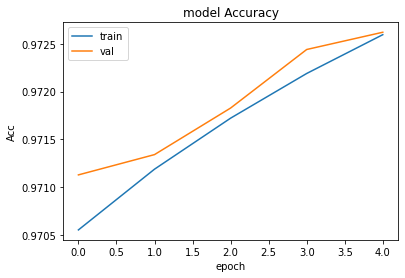

In [45]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [47]:
print(classification_report(targets, (np.array(preds) > 0.2).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     61266
         1.0       0.49      0.57      0.53      4041

    accuracy                           0.94     65307
   macro avg       0.73      0.77      0.75     65307
weighted avg       0.94      0.94      0.94     65307



## 1. в) Сложим эмбединги

In [48]:
class Clf_sum(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        embedded_mean = torch.sum(embedded, dim=1)
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [49]:
model = Clf_sum(len(word2id), embedding_dim=50, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [50]:
%%time
accs = []
accs_eval = []
for i in range(5):
    print('epoch:', i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

epoch: 0
Loss: 0.23256248077592095; Accuracy: 0.9356661348848849
Loss: 0.19365798038294937; Accuracy: 0.9405816189344672
Loss: 0.17705109896943863; Accuracy: 0.9431008252750916
Loss: 0.1668287042205141; Accuracy: 0.9448934499249813
epoch: 1
Loss: 0.12979553458658424; Accuracy: 0.953003785035035
Loss: 0.12925030827045203; Accuracy: 0.9525524480990495
Loss: 0.12915776845126123; Accuracy: 0.9523643297765922
Loss: 0.12826763360362167; Accuracy: 0.9524910524506126
epoch: 2
Loss: 0.12456796735196977; Accuracy: 0.9544857357357357
Loss: 0.12468242160733668; Accuracy: 0.9539945754127064
Loss: 0.12502396014798836; Accuracy: 0.9536681497999333
Loss: 0.12444630847271755; Accuracy: 0.9536866638534633
epoch: 3
Loss: 0.12296648694946244; Accuracy: 0.9551113613613613
Loss: 0.12316736632985076; Accuracy: 0.954426431965983
Loss: 0.12357206209977295; Accuracy: 0.9540615100866956
Loss: 0.12304234303111104; Accuracy: 0.9540236621655414
epoch: 4
Loss: 0.12223096540546394; Accuracy: 0.9554046233733734
Loss: 

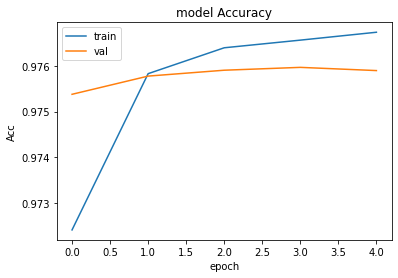

In [51]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [53]:
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61266
         1.0       0.61      0.60      0.61      4041

    accuracy                           0.95     65307
   macro avg       0.79      0.79      0.79     65307
weighted avg       0.95      0.95      0.95     65307



### Выводы:

Кажется,что разницы особо нет. Чуть хуже результаты получились при усреднении эмбедингов. 

## 2. Используем сразу две предобученные эмбединг модели (Fasttext и Word2Vec)

In [54]:
from gensim.models import FastText
from gensim.models import Word2Vec

In [55]:
texts = train_dataset.question_text.apply(preprocess).tolist()

In [57]:
ft = gensim.models.FastText(texts, size=100, iter=5)
w2v = gensim.models.Word2Vec(texts, size=100, iter=5)

In [58]:
weights_ft = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights_ft[i] = ft.wv[word]
    except KeyError:
        weights_ft[i] = ft.wv['опрагпллирао']

In [59]:
weights_w2v = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights_w2v[i] = w2v.wv[word]
    except KeyError:
        weights_w2v[i] = w2v.wv['опрагпллирао']

### Усредним эмбединги

In [60]:
class Clf_mean(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, 
                 embeddings_ft, embeddings_w2v, output_dim):
        
        super().__init__()          
        self.ft_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.w2v_embedding = nn.Embedding(vocab_size, embedding_dim)

        self.ft_embedding.from_pretrained(torch.tensor(embeddings_ft), freeze=True)
        self.w2v_embedding.from_pretrained(torch.tensor(embeddings_w2v), freeze=True)

        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded_ft = self.ft_embedding(text)   
        embedded_ft = torch.mean(embedded_ft, dim=1)

        embedded_w2v = self.w2v_embedding(text)   
        embedded_w2v = torch.mean(embedded_w2v, dim=1)

        embedded_mean = (embedded_w2v + embedded_ft) / 2
        
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [61]:
model = Clf_mean(len(word2id), embedding_dim=100,
            embeddings_ft=weights_ft, embeddings_w2v=weights_w2v, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [62]:
%%time
accs = []
accs_eval = []
for i in range(5):
    print('epoch:', i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
epoch: 0
Loss: 0.2179425110345011; Accuracy: 0.9387629817317318
Loss: 0.19392166302733685; Accuracy: 0.9400188375437719
Loss: 0.1793381263883601; Accuracy: 0.9416537283261087
Loss: 0.16958948484500608; Accuracy: 0.9431840381970492
epoch: 1
Loss: 0.13297896588349845; Accuracy: 0.9505990365365365
Loss: 0.13139236282339212; Accuracy: 0.9507097298649325
Loss: 0.130279259941913; Accuracy: 0.9507791659719906
Loss: 0.12917753353726122; Accuracy: 0.9510737059264817
epoch: 2
Loss: 0.1242385821098143; Accuracy: 0.9531562812812813
Loss: 0.12369920820064877; Accuracy: 0.9530272948974488
Loss: 0.12330367988290371; Accuracy: 0.953014286012004
Loss: 0.12278545284087165; Accuracy: 0.953088858152038
epoch: 3
Loss: 0.12071627068209338; Accuracy: 0.9545873998998999
Loss: 0.12047600239820931; Accuracy: 0.9543130940470235
Loss: 0.12028913478397775; Accuracy: 0.9541344510670223
Loss: 0.11992354985959054; Accuracy: 0.9541486934233558
epoch: 4
Lo

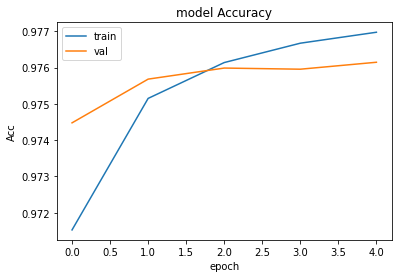

In [63]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [65]:
print(classification_report(targets, (np.array(preds) > 0.2).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     61266
         1.0       0.54      0.70      0.61      4041

    accuracy                           0.94     65307
   macro avg       0.76      0.83      0.79     65307
weighted avg       0.95      0.94      0.95     65307



## Конкатенируем эмбединги

In [66]:
class Clf_flatten(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, 
                 embeddings_ft, embeddings_w2v, output_dim):
        
        super().__init__()
        self.flatten = nn.Flatten()          
        self.ft_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.w2v_embedding = nn.Embedding(vocab_size, embedding_dim)

        self.ft_embedding.from_pretrained(torch.tensor(embeddings_ft), freeze=True)
        self.w2v_embedding.from_pretrained(torch.tensor(embeddings_w2v), freeze=True)

        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded_ft = self.ft_embedding(text)   
        embedded_ft = torch.mean(embedded_ft, dim=1)

        embedded_w2v = self.w2v_embedding(text)   
        embedded_w2v = torch.mean(embedded_w2v, dim=1)

        hidden_ft = self.flatten(embedded_ft)
        hidden_w2v = self.flatten(embedded_w2v)

        embedded_mean = (hidden_w2v + hidden_ft) / 2
        
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [67]:
model = Clf_flatten(len(word2id), embedding_dim=50,
            embeddings_ft=weights_ft, embeddings_w2v=weights_w2v, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [69]:
%%time
accs = []
accs_eval = []
for i in range(5):
    print('epoch:', i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

epoch: 0
Loss: 0.1544218701091376; Accuracy: 0.9448432807807807
Loss: 0.14965158926063088; Accuracy: 0.9457541270635318
Loss: 0.14647841545100726; Accuracy: 0.9463584215571857
Loss: 0.14382568614151692; Accuracy: 0.9470287493748437
epoch: 1
Loss: 0.13076668386314963; Accuracy: 0.9512168418418419
Loss: 0.129653538826512; Accuracy: 0.9512822817658829
Loss: 0.12898182656172516; Accuracy: 0.9512063917139046
Loss: 0.12837145152141016; Accuracy: 0.9513140003750937
epoch: 2
Loss: 0.12412415840499871; Accuracy: 0.9534260823323323
Loss: 0.12365955816374057; Accuracy: 0.9531347705102551
Loss: 0.12340982027399058; Accuracy: 0.952990840696899
Loss: 0.12315389573961594; Accuracy: 0.9529902006751688
epoch: 3
Loss: 0.12086097853588271; Accuracy: 0.95459131006006
Loss: 0.1206472135834273; Accuracy: 0.9541509035767884
Loss: 0.12055071241217043; Accuracy: 0.9539664263087696
Loss: 0.12039786903269144; Accuracy: 0.9539240278819705
epoch: 4
Loss: 0.1189750757541981; Accuracy: 0.9552482169669669
Loss: 0.118

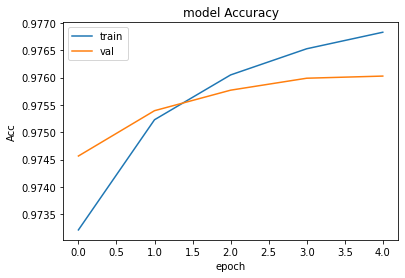

In [70]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [72]:
print(classification_report(targets, (np.array(preds) > 0.3).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     61266
         1.0       0.61      0.60      0.61      4041

    accuracy                           0.95     65307
   macro avg       0.79      0.79      0.79     65307
weighted avg       0.95      0.95      0.95     65307



### Выводы:

В целом, стало лучше! Заметнее это при усреднении эмбедингов